# Predictive Model - Box Office Revenues

The purpose of this notebook will be to import a tabular dataset, train a predictive model, and publish a web app (with a corresponding blog post) with visualizations to explain the model.

Here are my guidelines:


- I will explain the following: 
    - Why and how I chose my:
        - target, 
        - metric, and 
        - baseline
    - How I avoided data leakage,
    - When and why the model is useful (or not)
- I fit and evaluate a linear model for regression
    - I also use hyperparameter tuning to improve the performance of the linear model
    - (I will use Ridge regression as changing one parameter)
- I fit and evaluate a random forest or gradient boosting model for regression
    - I also use hyperparameter tuning to improve the performance of the tree-based model
- Notebook is well organized with Markdown headings and comments
    - I also can run all without errors
- **I commit all code to Github**
- I deploy an interactive web app using Plotly Dash on Heroku
- I write a corresponding blog post (minimum 300 words) to have on Plotly and Medium
    - I will report baseline score, validation scores from 2+ models, and test score from 1 selected model
    
    

### Final Results:

Baseline (Mean) R2 = -0.000994

Ridge Regression R2 (Validation) = 0.595994

Random Forest R2 (Validation) = 0.688077

XGBoost R2 (Validation): 0.70057

**Random Forest R2 (Test) = 0.681252**

**XGBoost R2 (Test) = 0.713650**

In [201]:
%%capture
!pip install category_encoders
!pip install forestci
!pip install duecredit

In [424]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import re
from datetime import datetime
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder, OrdinalEncoder
import forestci as fci
from xgboost import XGBRegressor


## Import Dataset

In [425]:
# Import the dataset

# Online file
data_url = 'https://raw.githubusercontent.com/AustinJamesWolff/Data-Science-Portfolio/main/Box%20Office%20Correlation/Movie%20Data/Movies%20with%20Bankability.csv'

def wrangle(filepath):
    df = pd.read_csv(data_url)
    df['released'] = pd.to_datetime(df['released'])
    
    # Drop duplicate titleId
    df.drop_duplicates(subset=['titleId'], inplace=True)
    df.dropna(subset=['gross'], inplace=True)
    
    pd.set_option('max_columns', None)
    df.reset_index(inplace=True)
    df.drop(columns=['index'], inplace=True)
    return df

df = wrangle(data_url)

display(df.head())
print(df.shape)

,titleId,title,rating,region,genre,released,year,month,day,score,director,writer,star,country,budget,gross,profit,company,runtime,category,nconst,primaryName,knownForTitlesList,topMovies,grossTopMovies,profitTopMovies,Avg_grossTopMovies,Avg_profitTopMovies,Total_Gross_Bankability,Total_Profit_Bankability
0,tt0081505,The Shining,R,US,Drama,1980-06-13,1980,June,13.0,8.4,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,27998772.0,Warner Bros.,146.0,actor,nm0000197,Jack Nicholson,tt0407887,The Departed,291465373.0,201465373.0,3.028217e+08,2.328217e+08,4.650644e+08,3.300644e+08
1,tt0080453,The Blue Lagoon,R,US,Adventure,1980-07-02,1980,July,2.0,5.8,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,54353106.0,Columbia Pictures,104.0,actress,nm0000222,Brooke Shields,tt0080453,The Blue Lagoon,58853106.0,54353106.0,5.885311e+07,5.435311e+07,9.625673e+07,8.259007e+07
2,tt0080684,Star Wars: Episode V - The Empire Strikes Back,PG,US,Action,1980-06-20,1980,June,20.0,8.7,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,520375067.0,Lucasfilm,124.0,actor,nm0000434,Mark Hamill,tt0086190,Star Wars: Episode VI - Return of the Jedi,475106177.0,442606177.0,7.820600e+08,6.595600e+08,9.515799e+08,7.968299e+08
3,tt0080339,Airplane!,PG,US,Comedy,1980-07-02,1980,July,2.0,7.7,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,79953539.0,Paramount Pictures,88.0,director,nm0000720,Jim Abrahams,tt0088286,Top Secret!,20458340.0,11458340.0,9.500268e+07,8.216935e+07,1.606221e+08,1.404318e+08
4,tt0080487,Caddyshack,R,US,Comedy,1980-07-25,1980,July,25.0,7.3,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,33846344.0,Orion Pictures,98.0,actor,nm0000331,Chevy Chase,tt0085995,National Lampoon's Vacation,61399552.0,46399552.0,5.014540e+07,3.314540e+07,2.182655e+08,1.801155e+08


(7278, 30)


In [456]:
# df.isnull().sum()

In [427]:
# Look at rows for purposes of data wrangling
# df['country'].value_counts()

## Feature Wrangling

In [428]:
# Let's create our X (features) and y (target)

def feature_wrangle(dataframe):
    
    temp_df = copy.deepcopy(dataframe)
    
    temp_df.drop(columns=['titleId','title','released','gross','profit','day','category','nconst',
                    'knownForTitlesList','topMovies','grossTopMovies','profitTopMovies',
                     'Avg_grossTopMovies','Avg_profitTopMovies',
                    'Total_Profit_Bankability'], inplace=True)
    
    # NOTE: Perhaps add "Total_Gross_Bankability" back in later to see how it affects the model
    
    # Drop columns with high cardinality, threshold below
    
    threshold = 20
    
    high_card_cols = [col for col in temp_df.select_dtypes('object').columns if
                     temp_df[col].nunique() > threshold]
    
    temp_df.drop(columns=high_card_cols, inplace=True)
    
    return temp_df

y = df['gross']
X = feature_wrangle(df)
X.head()

,rating,region,genre,year,month,score,budget,runtime,Total_Gross_Bankability
0,R,US,Drama,1980,June,8.4,19000000.0,146.0,4.650644e+08
1,R,US,Adventure,1980,July,5.8,4500000.0,104.0,9.625673e+07
2,PG,US,Action,1980,June,8.7,18000000.0,124.0,9.515799e+08
3,PG,US,Comedy,1980,July,7.7,3500000.0,88.0,1.606221e+08
4,R,US,Comedy,1980,July,7.3,6000000.0,98.0,2.182655e+08


In [457]:
# Examine the X data for further descrepancies.

# X.isnull().sum()

## Split The Data

In [430]:
# Split the data into training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Look at the shape
# print(X_init_train.shape)
print(X_test.shape)
# X_test.head()

(1456, 9)


## Now we find our Baseline

In [432]:
# We will now find a baseline

model_baseline = make_pipeline(
                OneHotEncoder(use_cat_names=True),
                DummyRegressor()
)

# model_baseline.fit(X_train, y_train)

scoring = ['neg_mean_absolute_error','neg_mean_absolute_percentage_error','r2']

cv_baseline = cross_validate(
    model_baseline,
    X_train,
    y_train,
    scoring=scoring,
    cv=5
)

cv_mae_baseline = -cv_baseline['test_neg_mean_absolute_error'].mean()
cv_mape_baseline = -cv_baseline['test_neg_mean_absolute_percentage_error'].mean()
cv_r2_baseline = cv_baseline['test_r2'].mean()


print('Baseline MAE:', '{:,}'.format(cv_mae_baseline.round(2)))

print('Baseline MAPE:', '{:,}'.format(cv_mape_baseline.round(6)))

print('Baseline R2 score:', '{:,}'.format(cv_r2_baseline.round(6)))


Baseline MAE: 93,947,168.94
Baseline MAPE: 282.409473
Baseline R2 score: -0.000994


In [433]:
model_results = []
model_results.append(['Baseline', cv_mae_baseline, cv_mape_baseline, cv_r2_baseline])

model_results

[['Baseline', 93947168.94098416, 282.4094726588083, -0.0009942019104258292]]

In [434]:
# Now we will begin finding the best model (and parameters)

# Linear Model #1
model_lr_1 = make_pipeline(
                OneHotEncoder(use_cat_names=True),
                SimpleImputer(strategy='mean'),
                LinearRegression()
)

cv_lr_1 = cross_validate(
    model_lr_1,
    X_train,
    y_train,
    scoring=scoring,
    cv=5
)

cv_mae_lr_1 = -cv_lr_1['test_neg_mean_absolute_error'].mean()
cv_mape_lr_1 = -cv_lr_1['test_neg_mean_absolute_percentage_error'].mean()
cv_r2_lr_1 = cv_lr_1['test_r2'].mean()

print('Linear Regression (1) MAE:', '{:,}'.format(cv_mae_lr_1.round(2)))

print('Linear Regression (1) MAPE:', '{:,}'.format(cv_mape_lr_1.round(6)))

print('Linear Regression (1) R2 score:', '{:,}'.format(cv_r2_lr_1.round(6)))


print()
model_results.append(['LinearRegression_1', cv_mae_lr_1, cv_mape_lr_1, cv_r2_lr_1])
print(model_results)

Linear Regression (1) MAE: 455,712,698.77
Linear Regression (1) MAPE: 178.76018
Linear Regression (1) R2 score: -14,205.471755

[['Baseline', 93947168.94098416, 282.4094726588083, -0.0009942019104258292], ['LinearRegression_1', 455712698.77130395, 178.76018046173718, -14205.471755238084]]


## It appears normal Linear Regression performs significantly worse than the baseline, without any hyperparameter tuning. Let's add another transformer.

In [435]:
# Linear Model #2, adding "StandardScaler"
model_lr_2 = make_pipeline(
                OneHotEncoder(use_cat_names=True),
                SimpleImputer(strategy='mean'),
                StandardScaler(),
                LinearRegression()
)

cv_lr_2 = cross_validate(
    model_lr_2,
    X_train,
    y_train,
    scoring=scoring,
    cv=5
)

cv_mae_lr_2 = -cv_lr_2['test_neg_mean_absolute_error'].mean()
cv_mape_lr_2 = -cv_lr_2['test_neg_mean_absolute_percentage_error'].mean()
cv_r2_lr_2 = cv_lr_2['test_r2'].mean()

print('Linear Regression (2) MAE:', '{:,}'.format(cv_mae_lr_2.round(2)))

print('Linear Regression (2) MAPE:', '{:,}'.format(cv_mape_lr_2.round(6)))

print('Linear Regression (2) R2 score:', '{:,}'.format(cv_r2_lr_2.round(6)))


print()
model_results.append(['LinearRegression_2', cv_mae_lr_2, cv_mape_lr_2, cv_r2_lr_2])
print(model_results)

Linear Regression (2) MAE: 4.039487079675694e+17
Linear Regression (2) MAPE: 3,207,677,317,315.1016
Linear Regression (2) R2 score: -3.033014419394398e+22

[['Baseline', 93947168.94098416, 282.4094726588083, -0.0009942019104258292], ['LinearRegression_1', 455712698.77130395, 178.76018046173718, -14205.471755238084], ['LinearRegression_2', 4.039487079675694e+17, 3207677317315.1016, -3.033014419394398e+22]]


Adding StandardScaler() made our Linear Regression even worse. Let's try Ridge.

In [436]:
# Ridge Model #1
model_ridge_1 = make_pipeline(
                OneHotEncoder(use_cat_names=True),
                SimpleImputer(strategy='mean'),
                StandardScaler(), # Wehave to include this. Without scaling our data, Ridge will give us an error.
                Ridge()
)

cv_ridge_1 = cross_validate(
    model_ridge_1,
    X_train,
    y_train,
    scoring=scoring,
    cv=5
)

cv_mae_ridge_1 = -cv_ridge_1['test_neg_mean_absolute_error'].mean()
cv_mape_ridge_1 = -cv_ridge_1['test_neg_mean_absolute_percentage_error'].mean()
cv_r2_ridge_1 = cv_ridge_1['test_r2'].mean()

print('Ridge Regression (1) MAE:', '{:,}'.format(cv_mae_ridge_1.round(2)))

print('Ridge Regression (1) MAPE:', '{:,}'.format(cv_mape_ridge_1.round(6)))

print('Ridge Regression (1) R2 score:', '{:,}'.format(cv_r2_ridge_1.round(6)))


print()
model_results.append(['Ridge_1', cv_mae_ridge_1, cv_mape_ridge_1, cv_r2_ridge_1])
print(model_results)

Ridge Regression (1) MAE: 64,164,252.97
Ridge Regression (1) MAPE: 130.469053
Ridge Regression (1) R2 score: 0.595777

[['Baseline', 93947168.94098416, 282.4094726588083, -0.0009942019104258292], ['LinearRegression_1', 455712698.77130395, 178.76018046173718, -14205.471755238084], ['LinearRegression_2', 4.039487079675694e+17, 3207677317315.1016, -3.033014419394398e+22], ['Ridge_1', 64164252.97296071, 130.4690532973758, 0.5957769203095545]]


Our Ridge Regression had a better MAE than the baseline! It had an improved R2 score as well. Let's try some different alpha values.

In [437]:
# Ridge Model #2
model_ridge_2 = make_pipeline(
                OneHotEncoder(use_cat_names=True),
                SimpleImputer(strategy='mean'),
                StandardScaler(),
                Ridge(alpha=100)
)

model_ridge_2.fit(X_train, y_train)

cv_ridge_2 = cross_validate(
    model_ridge_2,
    X_train,
    y_train,
    scoring=scoring,
    cv=5
)

cv_mae_ridge_2 = -cv_ridge_2['test_neg_mean_absolute_error'].mean()
cv_mape_ridge_2 = -cv_ridge_2['test_neg_mean_absolute_percentage_error'].mean()
cv_r2_ridge_2 = cv_ridge_2['test_r2'].mean()

print('Ridge Regression (2) MAE:', '{:,}'.format(cv_mae_ridge_2.round(2)))

print('Ridge Regression (2) MAPE:', '{:,}'.format(cv_mape_ridge_2.round(6)))

print('Ridge Regression (2) R2 score:', '{:,}'.format(cv_r2_ridge_2.round(6)))


model_results.append(['Ridge_2', cv_mae_ridge_2, cv_mape_ridge_2, cv_r2_ridge_2])


Ridge Regression (2) MAE: 63,796,418.02
Ridge Regression (2) MAPE: 128.287068
Ridge Regression (2) R2 score: 0.595994


Hyperparameter Tuning: Increasing the penalty coefficient alpha from 1 to 100 seems to have slightly improved our MAE (and slightly improved our R2 score). Let's try Random Forest now and see which model performs best before further tuning with RandomizedSearchCV.

In [438]:
# Random Forest Model #1, with OrdinalEncoder
model_forest_1 = make_pipeline(
                OrdinalEncoder(),
                SimpleImputer(strategy='mean'),
                RandomForestRegressor()
)

cv_forest_1 = cross_validate(
    model_forest_1,
    X_train,
    y_train,
    scoring=scoring,
    cv=5
)

cv_mae_rf_1 = -cv_forest_1['test_neg_mean_absolute_error'].mean()
cv_mape_rf_1 = -cv_forest_1['test_neg_mean_absolute_percentage_error'].mean()
cv_r2_rf_1 = cv_forest_1['test_r2'].mean()

print('Random Forest (1) MAE:', '{:,}'.format(cv_mae_rf_1.round(2)))

print('Random Forest (1) MAPE:', '{:,}'.format(cv_mape_rf_1.round(6)))

print('Random Forest (1) R2 score:', '{:,}'.format(cv_r2_rf_1.round(6)))


model_results.append(['RandomForest_1', cv_mae_rf_1, cv_mape_rf_1, cv_r2_rf_1])


Random Forest (1) MAE: 46,042,151.86
Random Forest (1) MAPE: 64.263601
Random Forest (1) R2 score: 0.679776


Random Forest had a higher R2 score and lower MAE and MAPE scores, so we will be moving forward with it. Before we use GridSearchCV (or RandomizedSearchCV if Grid takes too long), I just want to test OrdinalEncoder vs OneHotEncoder.

In [439]:
# Random Forest Model #2, with OneHotEncoder

model_forest_2 = make_pipeline(
                OneHotEncoder(use_cat_names=True),
                SimpleImputer(strategy='mean'),
                RandomForestRegressor(),
)

cv_forest_2 = cross_validate(
    model_forest_2,
    X_train,
    y_train,
    scoring=scoring,
    cv=5
)

cv_mae_rf_2 = -cv_forest_2['test_neg_mean_absolute_error'].mean()
cv_mape_rf_2 = -cv_forest_2['test_neg_mean_absolute_percentage_error'].mean()
cv_r2_rf_2 = cv_forest_2['test_r2'].mean()

print('Random Forest (2) MAE:', '{:,}'.format(cv_mae_rf_2.round(2)))

print('Random Forest (2) MAPE:', '{:,}'.format(cv_mape_rf_2.round(6)))

print('Random Forest (2) R2 score:', '{:,}'.format(cv_r2_rf_2.round(6)))

model_results.append(['RandomForest_2', cv_mae_rf_2, cv_mape_rf_2, cv_r2_rf_2])

Random Forest (2) MAE: 44,732,966.8
Random Forest (2) MAPE: 51.164988
Random Forest (2) R2 score: 0.693297


It appears OneHotEncoder() gave us better metrics, so we will move forward with that. This was a good lesson in testing your hyperparameters.

## Let's use a SearchCV to find optimal parameters for our RandomForest (Commented out to reduce computation time when running full notebook)

In [440]:
# Using SearchCV to tune our RandomForest


# params = {
#     "simpleimputer__strategy": ['mean','median'],
#     "randomforestregressor__n_estimators": [75, 100, 200],
#     "randomforestregressor__max_depth": [None, 100],
#     "randomforestregressor__min_samples_leaf": [1, 0.1],
# }


# model_grid_rf = GridSearchCV(
#     model_forest_2,
#     param_grid = params,
#     n_jobs=-1,
#     cv=5,
# #     verbose=3
# )

# model_grid_rf.fit(X_train, y_train)

# print(model_grid_rf.best_params_)

## We will now build a new RandomForest with these best parameters

In [442]:
# RaomdForest 3 with new hyperparameters

model_forest_3 = make_pipeline(
                OneHotEncoder(use_cat_names=True),
                SimpleImputer(strategy='mean'),
                RandomForestRegressor(max_depth=None,
                                     min_samples_leaf=1,
                                     n_estimators=100
                                     )
)

model_forest_3.fit(X_train, y_train)

cv_forest_3 = cross_validate(
    model_forest_3,
    X_train,
    y_train,
    scoring=scoring,
    cv=5
)

cv_mae_rf_3 = -cv_forest_3['test_neg_mean_absolute_error'].mean()
cv_mape_rf_3 = -cv_forest_3['test_neg_mean_absolute_percentage_error'].mean()
cv_r2_rf_3 = cv_forest_3['test_r2'].mean()

print('Random Forest (3) MAE:', '{:,}'.format(cv_mae_rf_3.round(2)))

print('Random Forest (3) MAPE:', '{:,}'.format(cv_mape_rf_3.round(6)))

print('Random Forest (3) R2 score:', '{:,}'.format(cv_r2_rf_3.round(6)))

model_results.append(['RandomForest_3', cv_mae_rf_3, cv_mape_rf_3, cv_r2_rf_3])

Random Forest (3) MAE: 44,574,296.85
Random Forest (3) MAPE: 51.626111
Random Forest (3) R2 score: 0.692829


## Now we will score the models on the test data

In [444]:
# Let's test Ridge_2 and RandomForest_3

print('Ridge Test R2 Score:', '{:,}'.format(model_ridge_2.score(X_test, y_test).round(6)))

print('Random Forest Test R2 Score:', '{:,}'.format(model_forest_3.score(X_test, y_test).round(6)))


Ridge Test R2 Score: 0.589758
Random Forest Test R2 Score: 0.675067


## Let's store our predictions into a DataFrame

In [445]:
y_pred = pd.DataFrame(model_forest_3.predict(X_test), index=X_test.index, columns=['Predictions'])
y_pred_df = y_pred.merge(y_test, how='outer', left_index=True, right_index=True)
y_pred_df

,Predictions,gross
6060,11667771.66,60159584.0
6626,98233642.94,9169507.0
6750,5274580.12,14725.0
3689,5517266.70,3645107.0
4516,5022367.20,916051.0
...,...,...
2876,89496337.94,43312294.0
325,21275840.44,2494480.0
2206,14051638.23,6608687.0
290,11247172.43,2914328.0


## Document and Visualize Permutation Importance

In [446]:
model_forest_3[1].feature_names_in_

array(['rating_R', 'rating_PG-13', 'rating_PG', 'rating_G',
       'rating_Not Rated', 'rating_NC-17', 'rating_Unrated',
       'rating_TV-PG', 'rating_TV-MA', 'rating_nan', 'rating_Approved',
       'rating_TV-14', 'rating_X', 'region_US', 'genre_Crime',
       'genre_Drama', 'genre_Action', 'genre_Fantasy', 'genre_Animation',
       'genre_Comedy', 'genre_Biography', 'genre_Adventure',
       'genre_Horror', 'genre_Romance', 'genre_Family', 'genre_Mystery',
       'genre_Western', 'genre_Thriller', 'genre_Music', 'genre_Sci-Fi',
       'genre_Sport', 'genre_Musical', 'year', 'month_August',
       'month_September', 'month_May', 'month_June', 'month_November',
       'month_February', 'month_March', 'month_December', 'month_January',
       'month_July', 'month_April', 'month_October', 'month_nan', 'score',
       'budget', 'runtime', 'Total_Gross_Bankability'], dtype=object)

In [447]:
importances = pd.Series(model_forest_3.steps[2][1].feature_importances_, model_forest_3[1].feature_names_in_)
importances

rating_R                   7.357117e-03
rating_PG-13               3.304115e-03
rating_PG                  2.975404e-03
rating_G                   1.253501e-03
rating_Not Rated           1.297115e-04
rating_NC-17               2.064261e-06
rating_Unrated             1.608985e-06
rating_TV-PG               4.594772e-05
rating_TV-MA               1.054099e-03
rating_nan                 4.457071e-04
rating_Approved            1.121437e-06
rating_TV-14               1.513335e-08
rating_X                   3.602520e-06
region_US                  0.000000e+00
genre_Crime                1.023748e-03
genre_Drama                2.937562e-03
genre_Action               4.052019e-03
genre_Fantasy              6.993743e-05
genre_Animation            7.991100e-03
genre_Comedy               2.366115e-03
genre_Biography            8.100896e-04
genre_Adventure            2.810452e-03
genre_Horror               1.995590e-03
genre_Romance              2.336132e-06
genre_Family               3.523277e-03


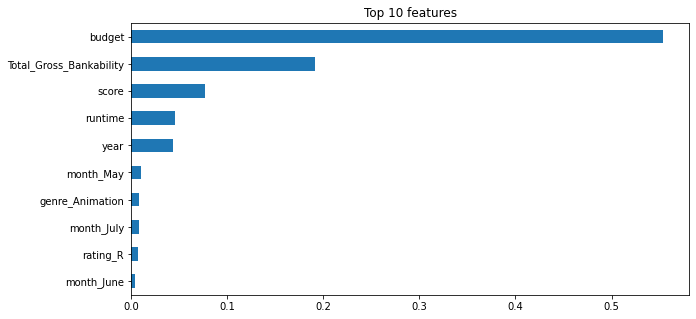

In [448]:
n = 10
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot(kind='barh')
plt.show()

## Let's see how permutation affects accuracy

In [449]:
perm_feature = 'budget'
X_test_permuted = copy.deepcopy(X_test)

X_test_permuted[perm_feature].fillna(X_test_permuted[perm_feature].median(), inplace=True)


In [450]:
X_test_permuted[perm_feature] = np.random.permutation(X_test[perm_feature])

print('Feature permuted:', perm_feature)
print('Validation Accuracy:', model_forest_3.score(X_test, y_test))
print('Validation Accuracy (permuted):', model_forest_3.score(X_test_permuted, y_test))

Feature permuted: budget
Validation Accuracy: 0.6750668670654216
Validation Accuracy (permuted): -0.12406118126553367


## Use XGBoost (Document results above)

In [451]:
# Try XGBoost

model_xgb_1 = make_pipeline(
                OneHotEncoder(use_cat_names=True),
                SimpleImputer(strategy='mean'),
                XGBRegressor(),
#                 verbose=2
)

model_xgb_1.fit(X_train, y_train)

cv_xgb_1 = cross_validate(
    model_xgb_1,
    X_train,
    y_train,
    scoring=scoring,
    cv=5
)

cv_mae_xgb_1 = -cv_xgb_1['test_neg_mean_absolute_error'].mean()
cv_mape_xgb_1 = -cv_xgb_1['test_neg_mean_absolute_percentage_error'].mean()
cv_r2_xgb_1 = cv_xgb_1['test_r2'].mean()

print('XGBoost (1) MAE:', '{:,}'.format(cv_mae_xgb_1.round(2)))

print('XGBoost (1) MAPE:', '{:,}'.format(cv_mape_xgb_1.round(6)))

print('XGBoost (1) R2 score:', '{:,}'.format(cv_r2_xgb_1.round(6)))

model_results.append(['XGB_1', cv_mae_xgb_1, cv_mape_xgb_1, cv_r2_xgb_1])

XGBoost (1) MAE: 46,871,928.98
XGBoost (1) MAPE: 70.922318
XGBoost (1) R2 score: 0.681246


In [452]:
model_xgb_1[2]

XGBRegressor()

## Tuning XGBoost Hyperparameters (Commented out to reduce computation time when running full notebook)

In [453]:
# Let's try different hyperparameters

# xgb_params = {
#     "xgbregressor__max_depth": [3,6,10],
#     "xgbregressor__learning_rate": [0.01,0.1,0.3],
#     "xgbregressor__n_estimators": [100, 500, 1000],
#     "xgbregressor__colsample_bytree": [0.1, 0.5, 1]
# }

# xgb_grid_1 = GridSearchCV(model_xgb_1,
#                          param_grid=xgb_params,
#                          n_jobs=-1,
#                         scoring='r2',
#                           cv=2,
#                          verbose=3)

# xgb_grid_1.fit(X_train, y_train)

# print(xgb_grid_1.best_params_)

# print(xgb_grid_1.best_score_)

## Use Best Parameters for XGBoost

In [454]:
model_xgb_2 = make_pipeline(
                OneHotEncoder(use_cat_names=True),
                SimpleImputer(strategy='mean'),
                XGBRegressor(colsample_bytree=0.5,
                            learning_rate=0.01,
                            max_depth=6,
                            n_estimators=1000),
#                 verbose=2
)

model_xgb_2.fit(X_train, y_train)

cv_xgb_2 = cross_validate(
    model_xgb_2,
    X_train,
    y_train,
    scoring=scoring,
    cv=5
)

cv_mae_xgb_2 = -cv_xgb_2['test_neg_mean_absolute_error'].mean()
cv_mape_xgb_2 = -cv_xgb_2['test_neg_mean_absolute_percentage_error'].mean()
cv_r2_xgb_2 = cv_xgb_2['test_r2'].mean()

print('XGBoost (2) MAE:', '{:,}'.format(cv_mae_xgb_2.round(2)))

print('XGBoost (2) MAPE:', '{:,}'.format(cv_mape_xgb_2.round(6)))

print('XGBoost (2) R2 score:', '{:,}'.format(cv_r2_xgb_2.round(6)))

model_results.append(['XGB_2', cv_mae_xgb_2, cv_mape_xgb_2, cv_r2_xgb_2])

XGBoost (2) MAE: 45,012,162.42
XGBoost (2) MAPE: 56.752657
XGBoost (2) R2 score: 0.70057


## Now let's try XGBoost on the test data

In [455]:
model_xgb_2.score(X_test, y_test)

0.7136500250873256

XGBoost with tuned hyperparameters performed the best on validation and testing data.

---

## Other things to try in the future:

1. Our data is right-skewed, so try log-transforming our gross column
2. Remove outliers (using any movies with a gross outside the 3rd IQR)
